In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
#Import all the necessary packages
import pandas as pd
import numpy as np
import keras as k
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import regularizers
from pickle import dump
from sklearn.model_selection import KFold
import tensorflowjs as tfjs
import keract
import datetime
import math

Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3595000761477948485
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4937233203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 668913008403759742
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
DROPOUT = 0.004
VALIDATION_SPLIT = 0.1
OPTIMIZER = 'adam'

LAYER_1 = 900
LAYER_2 = 150
LAYER_3 = 700
LAYER_4 = 550
LAYER_5 = 950
LAYER_6 = 950

In [5]:
# Create a model
def create_model():
    model = tf.keras.Sequential()    
    model.add(tf.keras.layers.Dense(128, input_dim=len(keys) - 1, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    def rmsle(y_true, y_pred):
        y_pred_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
        y_true_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
        return K.sqrt(K.mean(K.square(y_pred_log - y_true_log), axis = -1))

    model.compile(loss='mean_squared_error', 
                  optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
                 )
    
    return model

In [6]:
# Load the dataset
dataset = pd.read_csv("./Data/dataset_final.csv")

# Get keys
keys = dataset.keys()

# Target key
target = 'deptFreePrice'

# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale both the training inputs and outputs
scaled_train = scaler.fit_transform(dataset[keys])

print("Note: median values were scaled by multiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[6], scaler.min_[6]))

# Store the values to scale price back to understandable form
multiplied_by = scaler.scale_[6]
added = scaler.min_[6]

scalerData = {'scale_': scaler.scale_, 'min_': scaler.min_}
scalerDf = pd.DataFrame(scalerData, columns = ['scale_', 'min_'])


scaled_train = pd.DataFrame(scaled_train, columns=keys)

# Divide dataset into training and testing sets
msk = np.random.rand(len(scaled_train)) < 0.8

X, Y = scaled_train.drop(target, axis=1).values, scaled_train[target].values
X_train_2 =scaled_train[msk].values

X_train, X_test = scaled_train[msk].drop(target, axis=1).values, scaled_train[~msk].drop(target, axis=1).values
Y_train, Y_test = scaled_train[msk][target].values, scaled_train[~msk][target].values

print(len(X))
print(len(Y))
print(len(X_train))
print(len(X_test))

Note: median values were scaled by multiplying by 0.0000011173 and adding -0.111732
4043
4043
3226
817


In [192]:
# Callbacks for the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.90,
                              patience=10, min_lr=0.000001)
n_split = 10
h = []
e = []
j = 0
badIndexes = {}
#for train_index,test_index in KFold(n_split, True, 1).split(X_train_2):
    #x_train,x_test=X[train_index],X[test_index]
    #y_train,y_test=Y[train_index],Y[test_index]
  
    #model=create_model()
    #h.append(model.fit(x_train, y_train, batch_size=16, verbose=1,epochs=1000,callbacks=[mc]))
    #e.append({'Fold': j, 'MSE': model.evaluate(x_test,y_test)})
    #j += 1
    #if(j==2):
    #    badIndexes = {'x':train_index, 'y': test_index}
    #print('Model evaluation ',model.evaluate(x_test,y_test))

#log_dir = os.path.join("./logs/scalars/")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

# Create and run the model
model = create_model()
print(model.summary())
h = model.fit(
    X_train,
    Y_train,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=2000,
    shuffle=True,
    verbose=1,
    callbacks=[es, mc, reduce_lr 
               #tensorboard_callback
              ]
)

# Save the best model for later use
best_model_org = load_model('best_model.h5')


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 128)               5504      
_________________________________________________________________
dense_45 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_46 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_47 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_48 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_49 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_50 (Dense)             (None, 128)              

Epoch 28/2000
2304/2903 [======================>.......] - ETA: 0s - loss: 0.0017
Epoch 00028: val_loss did not improve from 0.00909
2903/2903 [==============================] - 0s 27us/sample - loss: 0.0018 - val_loss: 0.0117
Epoch 29/2000
2176/2903 [=====================>........] - ETA: 0s - loss: 0.0016
Epoch 00029: val_loss did not improve from 0.00909
2903/2903 [==============================] - 0s 31us/sample - loss: 0.0017 - val_loss: 0.0105
Epoch 30/2000
2048/2903 [====================>.........] - ETA: 0s - loss: 0.0015
Epoch 00030: val_loss did not improve from 0.00909
2903/2903 [==============================] - 0s 32us/sample - loss: 0.0016 - val_loss: 0.0103
Epoch 31/2000
1792/2903 [=================>............] - ETA: 0s - loss: 0.0016
Epoch 00031: val_loss did not improve from 0.00909
2903/2903 [==============================] - 0s 36us/sample - loss: 0.0016 - val_loss: 0.0099
Epoch 32/2000
1920/2903 [==================>...........] - ETA: 0s - loss: 0.0014
Epoch 0003

Epoch 64/2000
1280/2903 [============>.................] - ETA: 0s - loss: 8.7640e-04
Epoch 00064: val_loss did not improve from 0.00909
2903/2903 [==============================] - 0s 42us/sample - loss: 8.4999e-04 - val_loss: 0.0104
Epoch 65/2000
1792/2903 [=================>............] - ETA: 0s - loss: 7.9611e-04
Epoch 00065: val_loss did not improve from 0.00909
2903/2903 [==============================] - 0s 35us/sample - loss: 8.7371e-04 - val_loss: 0.0108
Epoch 66/2000
2304/2903 [======================>.......] - ETA: 0s - loss: 8.4635e-04
Epoch 00066: val_loss did not improve from 0.00909
2903/2903 [==============================] - 0s 27us/sample - loss: 9.1774e-04 - val_loss: 0.0123
Epoch 67/2000
2432/2903 [========================>.....] - ETA: 0s - loss: 8.8140e-04
Epoch 00067: val_loss did not improve from 0.00909
2903/2903 [==============================] - 0s 27us/sample - loss: 8.7677e-04 - val_loss: 0.0115
Epoch 68/2000
2432/2903 [========================>.....] - E

Epoch 99/2000
2560/2903 [=========================>....] - ETA: 0s - loss: 7.3464e-04
Epoch 00099: val_loss did not improve from 0.00909
2903/2903 [==============================] - 0s 25us/sample - loss: 7.2157e-04 - val_loss: 0.0132
Epoch 100/2000
2560/2903 [=========================>....] - ETA: 0s - loss: 7.1252e-04
Epoch 00100: val_loss did not improve from 0.00909
2903/2903 [==============================] - 0s 25us/sample - loss: 7.1788e-04 - val_loss: 0.0112
Epoch 101/2000
2432/2903 [========================>.....] - ETA: 0s - loss: 6.5079e-04
Epoch 00101: val_loss did not improve from 0.00909
2903/2903 [==============================] - 0s 27us/sample - loss: 6.2962e-04 - val_loss: 0.0123
Epoch 102/2000
2048/2903 [====================>.........] - ETA: 0s - loss: 6.0506e-04
Epoch 00102: val_loss did not improve from 0.00909
2903/2903 [==============================] - 0s 32us/sample - loss: 6.0545e-04 - val_loss: 0.0112
Epoch 103/2000
1920/2903 [==================>...........]

In [196]:
#Best model found by using WANDB developer tool
best_model = load_model('./models/wandb/model-best.h5')
best_model_2 = load_model('./models/wandb/model-best_2.h5')
best_model_3 = load_model('./models/wandb/model-best_3.h5')
best_model_4 = load_model('./models/wandb/model-best_4.h5')
best_model_5 = load_model('./models/wandb/model-best_5.h5')

MSE for the data set is: 0.001658357523372472


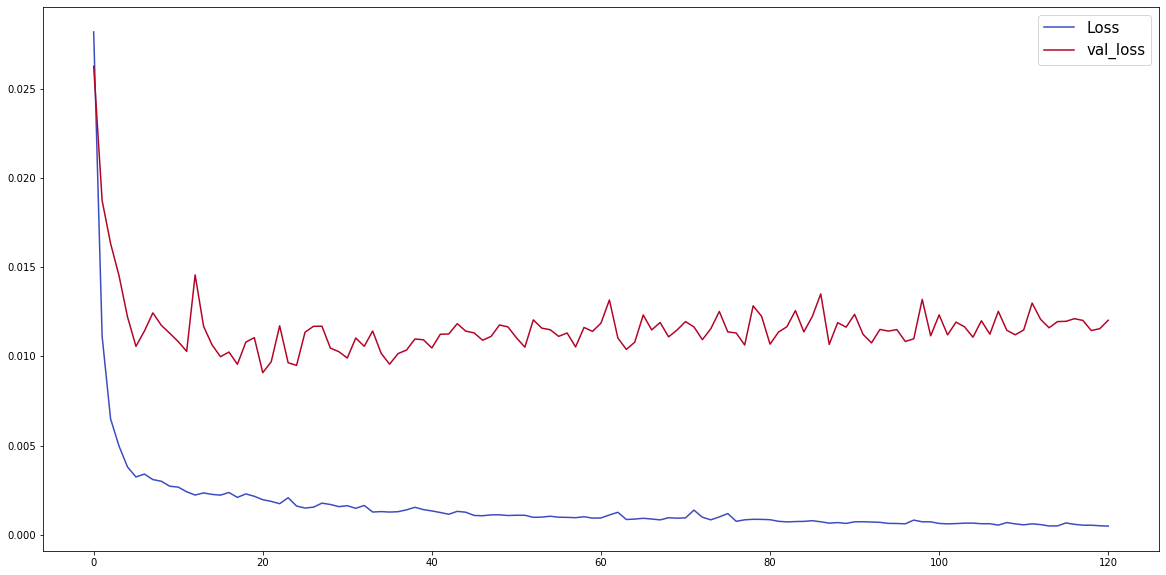

In [197]:
#Print the training history
fig, ax = plt.subplots(figsize=(20, 10))
lines = ax.plot(h.history['loss'], label='Loss')
lines = ax.plot(h.history['val_loss'], label='val_loss')
ax.legend(loc='upper right',fontsize=15)

test_error_rate = best_model.evaluate(X_train, Y_train, verbose=0)
print("MSE for the data set is: {}".format(test_error_rate))

In [211]:
predictors = keys.drop(target)

# Make predictions from test set
prediction = best_model.predict(X_test)

MAE = 0
RME = 0
RMSE = 0

pred_p = []
pred_p2 = []
pred_p3 = []
org_p = []

# Scale target values back to normal
for p in Y_test:
    y_2 = p
    y_2 -= added
    y_2 /= multiplied_by
    org_p.append(y_2)
    
org_p = np.asarray(org_p)

# Scale predicted values back to normal
for p in prediction:
    y_2 = p
    y_2 -= added
    y_2 /= multiplied_by
    pred_p.append(y_2)
    
# Calculate metrics for sensitivity analysis
for i in range(len(pred_p)):
    MAE += abs(pred_p[i] - org_p[i])
    RME += abs(pred_p[i] - org_p[i]) / org_p[i] * 100
    RMSE += (pred_p[i] - org_p[i])**2
    

MAE = float(MAE / len(pred_p))
RME = float(RME / len(pred_p))
RMSE = math.sqrt(RMSE / len(pred_p))
print(MAE)
print(RME)
print(RMSE)
newArray = np.asarray(pred_p)
#print("\nRMSPE for the data set is: {0:.2f}%".format(error_p))

print(org_p.shape)
print(newArray.shape)

# Calculate r squared
org_p = org_p.reshape((817,))
newArray = newArray.reshape((817,))
correlation_matrix = np.corrcoef(org_p, newArray)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

23320.873046875
8.325565338134766
33232.23302758935
(817,)
(817, 1)
0.9483329544524007


314070.84
283000.0
(817,)
1
Min value - 115826.23  Min original -  101000.0
Max value - 960688.75  Max original -  990000.0
Mean - 311228.25  Mean original -  305065.43772337824
Std - 139710.78  Std original -  143663.35221658647
DIF:  -0.00027964749506399506

MSE for the data set is: 0.0014


(array([      0.,  200000.,  400000.,  600000.,  800000., 1000000.,
        1200000.]), <a list of 7 Text yticklabel objects>)

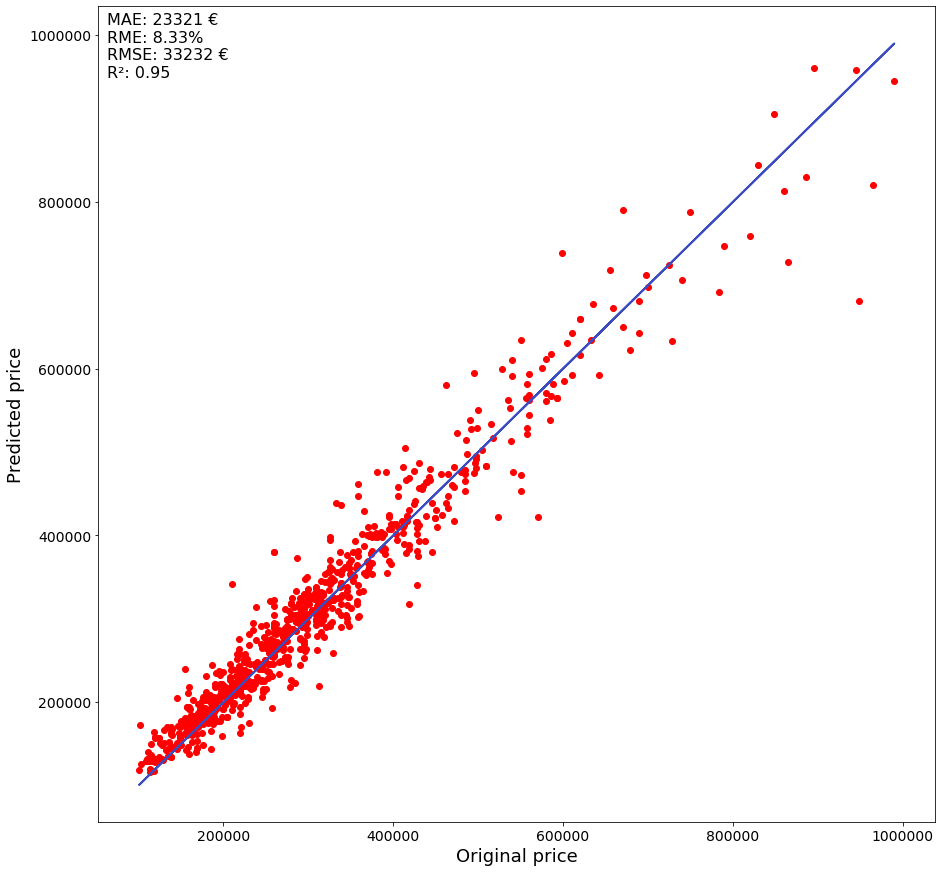

In [212]:
from matplotlib import rcParams, cycler

print("Min value -", min(newArray), " Min original - ", min(org_p))
print("Max value -", max(newArray), " Max original - ", max(org_p))
print("Mean -", np.nanmean(newArray), " Mean original - ", np.nanmean(org_p))
print("Std -", np.nanstd(newArray), " Std original - ", np.nanstd(org_p))

error_rate = best_model.evaluate(X_test, Y_test, verbose=0)
print("DIF: ", (error_rate - test_error_rate))
print("\nMSE for the data set is: {0:.4f}".format(error_rate))

cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, 2)))

# Print the predictions and targeted prices
fig, ax = plt.subplots(figsize=(15, 15))
lines = ax.plot(org_p, org_p, label='Predicted', linewidth=2)
ax.scatter(org_p, newArray, color='r')
ax.set_xlabel('Original price',fontsize=18)
ax.set_ylabel('Predicted price',fontsize=18)

txt = '\n'.join(("MAE: {0:.0f} €".format(MAE), "RME: {0:.2f}%".format(RME), "RMSE: {0:.0f} €".format(RMSE), "R²: {0:.2f}".format(r_squared)))
ax.text(0.01, 0.91, txt, fontsize=16,
               verticalalignment='bottom', transform=ax.transAxes)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [214]:
# Calculate sensitivity analysis for each room type
rooms = []
pred_sep = [[], [], [], [], [], []]
org_sep = [[], [], [], [], [], []]
stats = []
for i in range(len(X_test)):
    scaled = math.floor((X_test[i][3] - scaler.min_[3]) / scaler.scale_[3])
    rooms.append(scaled)
    
for i in range(len(newArray)):
    if rooms[i] == 1:
        pred_sep[0].append(newArray[i])
        org_sep[0].append(org_p[i])
    elif rooms[i] == 2:
        pred_sep[1].append(newArray[i])
        org_sep[1].append(org_p[i])
    elif rooms[i] == 3:
        pred_sep[2].append(newArray[i])
        org_sep[2].append(org_p[i])
    elif rooms[i] == 4:
        pred_sep[3].append(newArray[i])
        org_sep[3].append(org_p[i])
    elif rooms[i] == 5:
        pred_sep[4].append(newArray[i])
        org_sep[4].append(org_p[i])
    elif rooms[i] == 6:
        pred_sep[5].append(newArray[i])
        org_sep[5].append(org_p[i])
      

for n in range(len(pred_sep)):
    for i in range(len(pred_sep[n])):
        MAE += abs(pred_sep[n][i] - org_sep[n][i])
        RME += abs(pred_sep[n][i] / org_sep[n][i] - 1) * 100
        RMSE += (pred_sep[n][i] - org_sep[n][i])**2

    correlation_matrix = np.corrcoef(org_sep[n], pred_sep[n])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    MAE = MAE / len(pred_sep[n])
    RME = RME / len(pred_sep[n])
    RMSE = math.sqrt(RMSE / len(pred_sep[n]))
    stats.append([MAE,RME,RMSE,r_squared])
    MAE, RME, RMSE = 0, 0, 0

print(stats)

[[18329.39915531517, 9.115760385440007, 24365.823791975272, 0.8800033819288181], [20606.306053314696, 8.154917373656778, 28222.32272844262, 0.9437376308301402], [25804.80205195783, 8.119345543883703, 38430.00922171203, 0.9349564534440795], [29743.508049242424, 9.045208528737414, 38703.161362382496, 0.9530557636322816], [24786.3566015625, 5.292388211234174, 35173.41986743031, 0.9525933284681801], [45571.90401785716, 14.961291596888406, 63119.48403356005, 0.8913788826248188]]


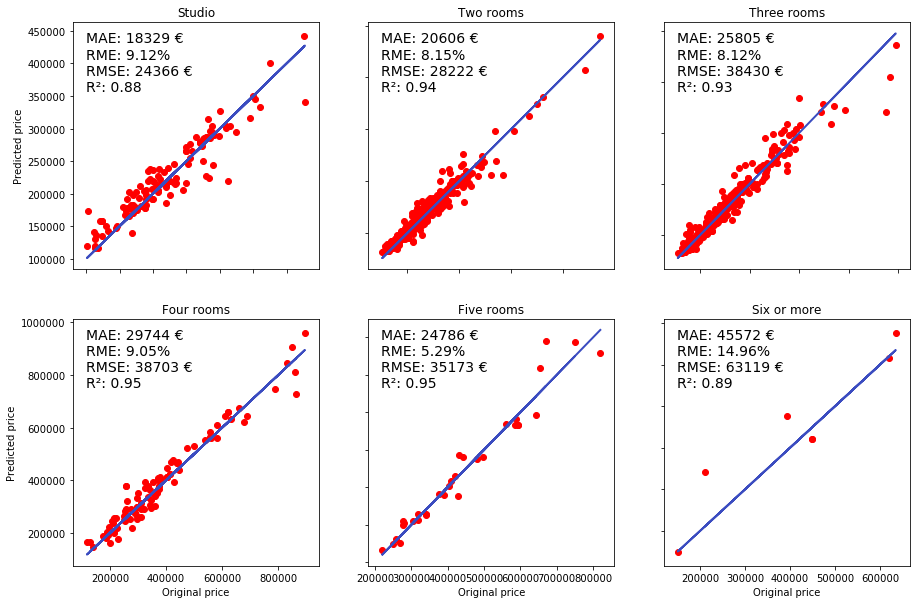

In [216]:

# Draw the graph for each room type
# Red points are predictions and blue line is targeted price
fig2, ax2 = plt.subplots(2, 3, figsize=(15, 10))
ax2[0, 0].plot(org_sep[0], org_sep[0], label='Predicted', linewidth=2)
ax2[0, 0].scatter(org_sep[0], pred_sep[0], color='r')
ax2[0, 0].set_title('Studio')
ax2[0, 1].plot(org_sep[1], org_sep[1], label='Predicted', linewidth=2)
ax2[0, 1].scatter(org_sep[1], pred_sep[1], color='r')
ax2[0, 1].set_title('Two rooms')

ax2[0, 2].plot(org_sep[2], org_sep[2], label='Predicted', linewidth=2)
ax2[0, 2].scatter(org_sep[2], pred_sep[2], color='r')
ax2[0, 2].set_title('Three rooms')

ax2[1, 0].plot(org_sep[3], org_sep[3], label='Predicted', linewidth=2)
ax2[1, 0].scatter(org_sep[3], pred_sep[3], color='r')
ax2[1, 0].set_title('Four rooms')

ax2[1, 1].plot(org_sep[4], org_sep[4], label='Predicted', linewidth=2)
ax2[1, 1].scatter(org_sep[4], pred_sep[4], color='r')
ax2[1, 1].set_title('Five rooms')

ax2[1, 2].plot(org_sep[5], org_sep[5], label='Predicted', linewidth=2)
ax2[1, 2].scatter(org_sep[5], pred_sep[5], color='r')
ax2[1, 2].set_title('Six or more')

txt = '\n'.join(("MAE: {0:.0f} €".format(stats[0][0]), "RME: {0:.2f}%".format(stats[0][1]), "RMSE: {0:.0f} €".format(stats[0][2]), "R²: {0:.2f}".format(stats[0][3])))
ax2[1, 2].text(-2.6, 1.7, txt, fontsize=14,
               verticalalignment='bottom', transform=ax.transAxes)

txt = '\n'.join(("MAE: {0:.0f} €".format(stats[1][0]), "RME: {0:.2f}%".format(stats[1][1]), "RMSE: {0:.0f} €".format(stats[1][2]), "R²: {0:.2f}".format(stats[1][3])))
ax2[1, 2].text(-1.4, 1.7, txt, fontsize=14,
               verticalalignment='bottom', transform=ax.transAxes)

txt = '\n'.join(("MAE: {0:.0f} €".format(stats[2][0]), "RME: {0:.2f}%".format(stats[2][1]), "RMSE: {0:.0f} €".format(stats[2][2]), "R²: {0:.2f}".format(stats[2][3])))
ax2[1, 2].text(-0.2, 1.7, txt, fontsize=14,
               verticalalignment='bottom', transform=ax.transAxes)

txt = '\n'.join(("MAE: {0:.0f} €".format(stats[3][0]), "RME: {0:.2f}%".format(stats[3][1]), "RMSE: {0:.0f} €".format(stats[3][2]), "R²: {0:.2f}".format(stats[3][3])))
ax2[1, 2].text(-2.6, 0.5, txt, fontsize=14,
               verticalalignment='bottom', transform=ax.transAxes)

txt = '\n'.join(("MAE: {0:.0f} €".format(stats[4][0]), "RME: {0:.2f}%".format(stats[4][1]), "RMSE: {0:.0f} €".format(stats[4][2]), "R²: {0:.2f}".format(stats[4][3])))
ax2[1, 2].text(-1.4, 0.5, txt, fontsize=14,
               verticalalignment='bottom', transform=ax.transAxes)

txt = '\n'.join(("MAE: {0:.0f} €".format(stats[5][0]), "RME: {0:.2f}%".format(stats[5][1]), "RMSE: {0:.0f} €".format(stats[5][2]), "R²: {0:.2f}".format(stats[5][3])))
ax2[1, 2].text(-0.2, 0.5, txt, fontsize=14,
               verticalalignment='bottom', transform=ax.transAxes)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

for ax in ax2.flat:
    ax.set(xlabel='Original price', ylabel='Predicted price')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in ax2.flat:
    ax.label_outer()

In [186]:
#tfjs.converters.save_keras_model(best_model, './models/wandb/')
#tfjs.converters.save_keras_model(model, './models/etuovi_model13/')
#scalerDf.to_csv(r'.\models\wandb\scaler.csv')

c:\users\jussi kalliola\appdata\local\programs\python\python36\lib\site-packages\tensorflowjs\converters\keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
